In [1]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities

from community import community_louvain


import numpy as np
import scipy as sp
import pandas as pd


# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
#convert between protein naming schemes

# get the name the biologists use from the name used in networkX
def get_protein_aliases(protein_codes, alias_type='BLAST_UniProt_GN_Name'):
    
    matched_dict = {}
    
    f = open("4932.protein.aliases.v11.5.txt", "r")
    for x in f:
        words = x.replace('\n','').split('\t')
        if (words[2] == alias_type): 
              if words[0] in protein_codes:
                    matched_dict[words[0]] = words[1]          
    f.close() 
    
    return matched_dict


# get the name used in networkX from the name the biologists use
def get_protein_codes(aliases, alias_type='BLAST_UniProt_GN_Name'):
    
    matched_dict = {}
    
    f = open("4932.protein.aliases.v11.5.txt", "r")
    for x in f:
        words = x.replace('\n','').split('\t')
        if len(words)!= 3: print(len(words))
            
        if (words[2] == alias_type): 
              if words[1] in aliases:
                    matched_dict[words[0]] = words[1]          
    f.close() 
    
    return matched_dict


In [3]:
#load wighted yeast network
file_name = '4932.protein.links.v11.5'
G0 = nx.read_weighted_edgelist(file_name + '.txt',comments='#',nodetype=str)
nx.info(G0)
print(G0.has_node('4932.YLR229C'))

True


In [4]:
# delete those edges with a combined score of <= threshold_score (small confidence)
# threshold_score = 950
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
nx.info(G0)

print(G0.has_node('4932.YLR229C'))

True


In [5]:
print('Is the full G0 connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

Is the full G0 connected? False
How many connected subgraphs are there? 441


In [6]:
# load list of essential proteins
import csv

with open('YeastEssentialProteins.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))

print('number of essential proteins:', len(data))    
    
# for row in data:
#     print(row[1])

number of essential proteins: 1313


In [7]:
# remove essential proteins from network

for row in data:
    node_string = '4932.'+row[1]
    if node_string not in G0:
        print(node_string, 'not in G0')
    else:
        G0.remove_node(node_string)
    
nx.info(G0)
print(G0.has_node('4932.YLR229C'))

4932.YAL034C-B not in G0
4932.YDL152W not in G0
4932.YDL221W not in G0
4932.YDR355C not in G0
4932.YGR265W not in G0
4932.YLL037W not in G0
4932.YLR458W not in G0
4932.YNCL0012C not in G0
4932.YNCL0021C not in G0
4932.YNCE0011C not in G0
4932.YNCJ0003C not in G0
4932.YNCL0045W not in G0
4932.YNCC0013W not in G0
4932.YNCK0002C not in G0
4932.YNCN0013W not in G0
4932.YNCL0003W not in G0
4932.YIL102C-A not in G0
False


In [8]:
print('Is the full G0 connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

Is the full G0 connected? False
How many connected subgraphs are there? 439


In [9]:
#get the largest component
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc)

print('number of nodes in first 20 biggests components:', [len(c) for c in sorted(nx.connected_components(G0), key=len, reverse=True)][0:20])
print('number of nodes of largest connected subgraph of G0:',G.number_of_nodes())
print('number of edges of largest connected subgraph of G0:',G.number_of_edges())

number of nodes in first 20 biggests components: [4639, 7, 5, 4, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
number of nodes of largest connected subgraph of G0: 4639
number of edges of largest connected subgraph of G0: 53312


# Louvain Community Detection

In [10]:
#Run Louvain community detection algorithm
partLouvain = community_louvain.best_partition(G)

# get info about the number of communities and which community proteins of interest belong
number_of_communities = max(list(partLouvain.values()))+1
print('# of partitions for Louvain modularity =',number_of_communities)

node_target = '4932.YGR241C' # YAP1802
print('The target protein YAP1802 belongs to community #',partLouvain[node_target])

node_target = '4932.YLL001W' # DNM1
print('The target protein DNM1 belongs to community #',partLouvain[node_target])

node_taget = '4932.YNL106C' # INP52
print('The target protein INP52 belongs to community #',partLouvain[node_target])

node_taget = '4932.YJR066W' # TOR1
print('The target protein TOR1 belongs to community #',partLouvain[node_target])

node_taget = '4932.YDL042C' # SIR2
print('The target protein SIR2 belongs to community #',partLouvain[node_target])



# of partitions for Louvain modularity = 17
The target protein YAP1802 belongs to community # 7
The target protein DNM1 belongs to community # 7
The target protein INP52 belongs to community # 7
The target protein TOR1 belongs to community # 7
The target protein SIR2 belongs to community # 7
{'4932.YLR229C': 'CDC42'}
False


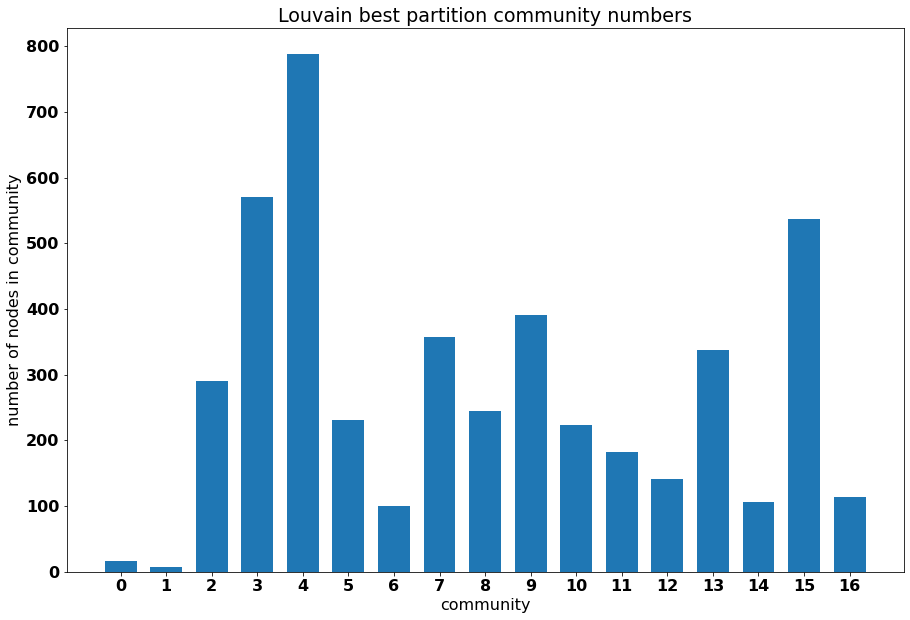

In [11]:
# Plot histogram of the number of proteins in each community
fig = plt.figure(figsize=(15.0,10.0))

bin_edges = np.arange(-0.5, number_of_communities+0.5, 1)
plt.hist(list(partLouvain.values()), bins = bin_edges, rwidth = 0.7)
plt.xlabel('community')
plt.ylabel('number of nodes in community')
plt.title('Louvain best partition community numbers')
plt.xticks(np.arange(0, number_of_communities, 1));

## YAP community

In [12]:
# Create subgraph of YAP1802's community
node_target = '4932.YGR241C' # YAP1802
target_com = partLouvain[node_target]
sub = []

for idx, node in enumerate(G):
    if partLouvain[node] == target_com:
        sub.append(node)
        
Gp = G.subgraph(sub)

nx.info(Gp)

'Graph with 357 nodes and 2196 edges'

In [13]:
# Compute highest centrality nodes in YAP's community
measureNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness","Closeness","Subgraph"]
listMeasures = [dict(nx.degree(Gp)),nx.eigenvector_centrality_numpy(Gp),nx.katz_centrality_numpy(Gp),nx.pagerank(Gp),nx.betweenness_centrality(Gp),nx.closeness_centrality(Gp),nx.subgraph_centrality(Gp)]

for idx,dictMeasure in enumerate(listMeasures):
    top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
    top10.sort(reverse=True)
    print("\n Centrality Measure:",measureNames[idx])
    for idx,pair in enumerate(top10[:10]):
        print(str(idx+1),": \t is node ",get_protein_aliases(pair[1])," with value:\t",pair[0])


 Centrality Measure: Degree
1 : 	 is node  {'4932.YML001W': 'YPT7'}  with value:	 51
2 : 	 is node  {'4932.YAL030W': 'SNC1'}  with value:	 50
3 : 	 is node  {'4932.YOR089C': 'VPS21'}  with value:	 46
4 : 	 is node  {'4932.YJL154C': 'VPS35'}  with value:	 45
5 : 	 is node  {'4932.YNR006W': 'VPS27'}  with value:	 43
6 : 	 is node  {'4932.YLR262C': 'YPT6'}  with value:	 43
7 : 	 is node  {'4932.YGR167W': 'CLC1'}  with value:	 41
8 : 	 is node  {'4932.YDR388W': 'RVS167'}  with value:	 41
9 : 	 is node  {'4932.YBL037W': 'APL3'}  with value:	 38
10 : 	 is node  {'4932.YNL084C': 'END3'}  with value:	 36

 Centrality Measure: Eigenvector
1 : 	 is node  {'4932.YGR167W': 'CLC1'}  with value:	 0.18396060401610706
2 : 	 is node  {'4932.YKR001C': 'VPS1'}  with value:	 0.17740924401606986
3 : 	 is node  {'4932.YNL084C': 'END3'}  with value:	 0.17202579878767263
4 : 	 is node  {'4932.YBL037W': 'APL3'}  with value:	 0.17149578008926905
5 : 	 is node  {'4932.YBL047C': 'EDE1'}  with value:	 0.168251750

# Backbone of YAP community

In [14]:
# Do backbone detection = make subgraph of high centrality nodes in YAP's community

measureNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness","Closeness","Subgraph"]
listMeasures = [dict(nx.degree(Gp)),nx.eigenvector_centrality_numpy(Gp),nx.katz_centrality_numpy(Gp),nx.pagerank(Gp),nx.betweenness_centrality(Gp),nx.closeness_centrality(Gp),nx.subgraph_centrality(Gp)]

sub = []

# rank threshold out of 1 to include, for each centrality measure
backboneCriteria = [-1,-1,-1,-1,.05,-1,-1]

for node in G:
    
    included = False
    
    for idx,dictMeasure in enumerate(listMeasures):
        
        if backboneCriteria[idx] == -1: continue
            
        topNThreshold = int(backboneCriteria[idx]*Gp.number_of_nodes())
        
        topN = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the largest values
        topN.sort(reverse=True)
        for pair in topN[:topNThreshold]:
            if node == pair[1]:
                included = True
                break
    
    if included: 
        sub.append(node)

        
# sub.append('4932.YGR241C') # YAP1802 
# sub.append('4932.YNL106C')
        
Gb = Gp.subgraph(sub)
print(nx.info(Gb))
print('Is Gb connected?',nx.connected.is_connected(Gb))

Graph with 17 nodes and 53 edges
Is Gb connected? True


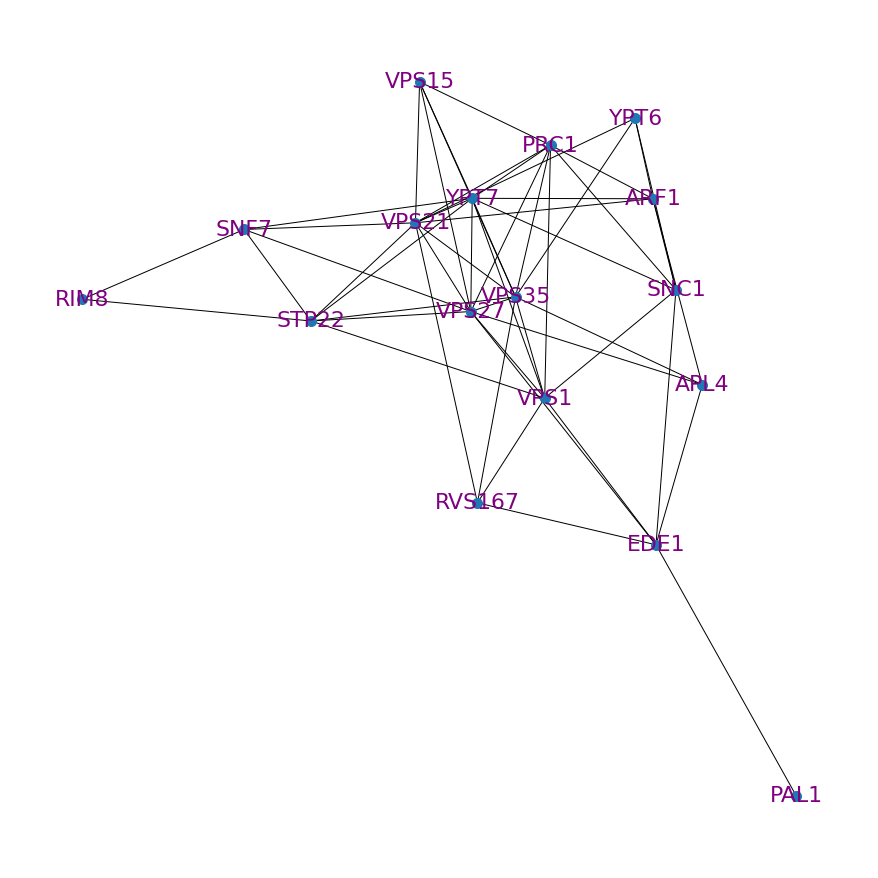

In [15]:
# Plot "backbone" of YAP's community
pos = nx.spring_layout(Gb, seed=3113794753)  # positions for all nodes

labels = get_protein_aliases(list(Gb))

plt.figure(1,figsize=(12,12)) 
nx.draw(Gb, pos, node_size = 100)
nx.draw_networkx_labels(Gb,pos,labels, font_size=22, font_color="purple")
plt.show()

# Backbone of entire network

In [16]:
# percentage of high centrality nodes to include in the backbone in each community, as a decimal
backbone_threshold = 0.03


In [17]:
# compute backbone of entire network by including 
# the top [backbone_threshold * number of nodes in community] nodes for each community. 
# Assign colours to communities for plotting.

import random as rd

centrality = nx.betweenness_centrality(G)

node_target = '4932.YGR241C' # YAP1802
target_com = partLouvain[node_target]
sub = []

colors = []
#colour of target community
target_colour = 'yellow'

for c in range(number_of_communities):
    
    print(c)
    
    if c == target_com:
        color = target_colour
    else:
        color = (rd.random()/3,rd.random()/3,rd.random()/3)
    
    
    com_centrality = {}
    
    for node in G:
        if partLouvain[node] == c:
            com_centrality[node] = centrality[node]
    
    topNThreshold = int(backbone_threshold*len(com_centrality))

    topN = [[com_centrality[k],k] for k in com_centrality.keys()] # Choose the largest values
    topN.sort(reverse=True)
    for node in G:
        included = False
        for pair in topN[:topNThreshold]:
            if node == pair[1]:
                included = True
                break
    
        if included: 
            sub.append(node)
            colors.append(color)

            
print(nx.info(G))            
Gbb = G.subgraph(sub)
print(nx.info(Gbb))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Graph with 4639 nodes and 53312 edges
Graph with 132 nodes and 497 edges


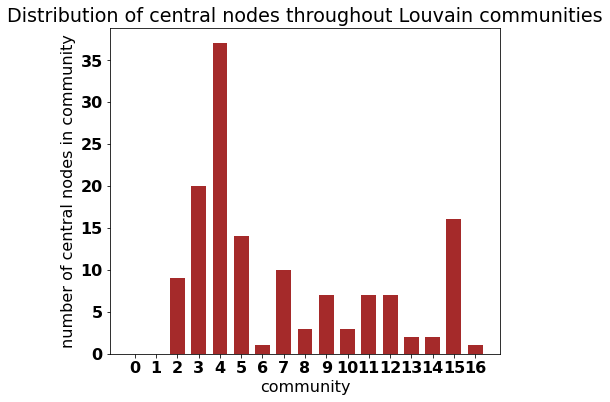

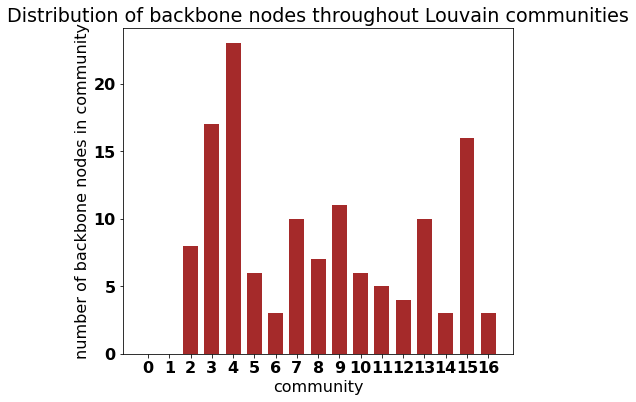

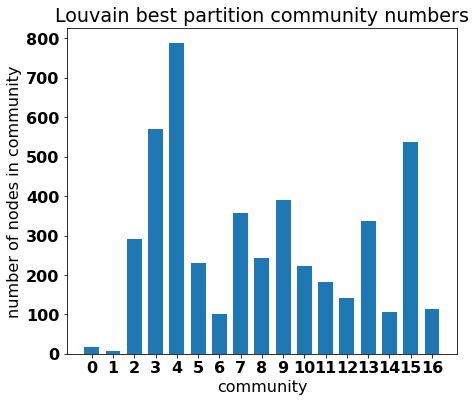

In [18]:
# Plot number of important nodes in each community (ie. to compare to number of nodes in each community
# to see if they are proportional )

sub = []

topNThreshold = int(backbone_threshold*G.number_of_nodes())
topN = [[centrality[k],k] for k in centrality.keys()] # Choose the largest values
topN.sort(reverse=True)

for node in G:
    included = False
    for pair in topN[:topNThreshold]:
        if node == pair[1]:
            included = True
            break

    if included: 
        sub.append(node)

        
partLouvainImportant = {key: partLouvain[key] for key in sub}

fig = plt.figure(figsize=(7.0,6.0))

bin_edges = np.arange(-0.5, number_of_communities+0.5, 1)
plt.hist(list(partLouvainImportant.values()), bins = bin_edges, rwidth = 0.7, color = 'brown')
plt.xlabel('community')
plt.ylabel('number of central nodes in community')
plt.title('Distribution of central nodes throughout Louvain communities')
plt.xticks(np.arange(0, number_of_communities, 1));


# Plot number of backbone nodes in each community (should reflect numbers in each community exactly) 
partLouvainImportant = {key: partLouvain[key] for key in Gbb}

fig = plt.figure(figsize=(7.0,6.0))

bin_edges = np.arange(-0.5, number_of_communities+0.5, 1)
plt.hist(list(partLouvainImportant.values()), bins = bin_edges, rwidth = 0.7, color = 'brown')
plt.xlabel('community')
plt.ylabel('number of backbone nodes in community')
plt.title('Distribution of backbone nodes throughout Louvain communities')
plt.xticks(np.arange(0, number_of_communities, 1));



# Plot distribution of community numbers for comparison
fig = plt.figure(figsize=(7.0,6.0))

bin_edges = np.arange(-0.5, number_of_communities+0.5, 1)
plt.hist(list(partLouvain.values()), bins = bin_edges, rwidth = 0.7)
plt.xlabel('community')
plt.ylabel('number of nodes in community')
plt.title('Louvain best partition community numbers')
plt.xticks(np.arange(0, number_of_communities, 1));



sizes of connected components of backbone: [128, 2, 1, 1]


D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4932.YLR149C  not in alias list
4932.YLL067C  not in alias list
4932.YPR080W  not in alias list
4932.YHR219W  not in alias list
4932.YLR462W  not in alias list
4932.YHR218W  not in alias list
4932.YKR094C  not in alias list
4932.YBR062C  not in alias list


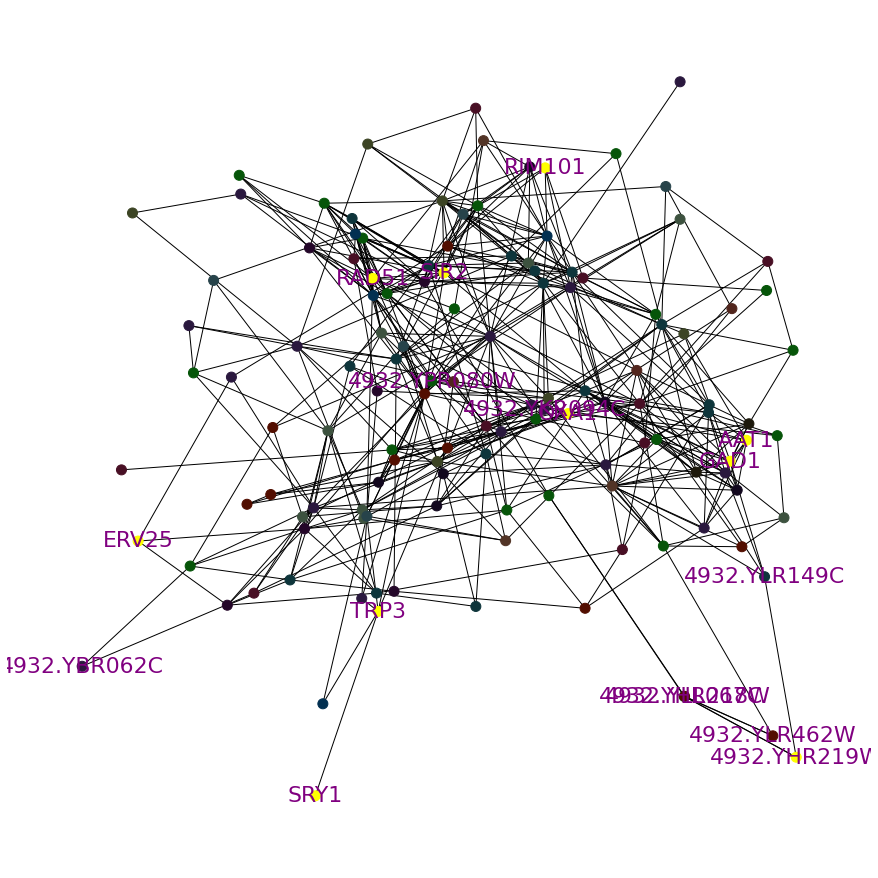

In [19]:
# Plot the backbone of the entire network


print('sizes of connected components of backbone:', [len(c) for c in sorted(nx.connected_components(Gbb), key=len, reverse=True)])
largest_cc = max(nx.connected_components(Gbb),key=len)

Gbbb = Gbb.subgraph(largest_cc)

colors2 = []
for idx, node in enumerate(Gbb):
    if node in Gbbb:
        colors2.append(colors[idx])

pos = nx.spring_layout(Gbbb, seed=3113694753)  # positions for all nodes

plt.figure(1,figsize=(12,12)) 
nx.draw(Gbbb, pos, node_color=colors2, node_size = 100)

labels = get_protein_aliases(list(Gbbb))
for idx,node in enumerate(Gbbb):
    if node not in labels:
        print(node, ' not in alias list')
        labels[node] = node
    elif colors2[idx]!= target_colour:
        labels[node] = ''
#     else:
# #         print(labels[node])

nx.draw_networkx_labels(Gbbb,pos,labels, font_size=22, font_color="purple")
# nx.draw_networkx_labels(Gb,pos,labels, font_size=22, font_color="purple")
plt.show()

## Paths in the network

In [21]:
# paths between YAP and SIR2/TOR1, including backbone nodes
path = nx.shortest_path(G,'4932.YGR241C','4932.YDL042C')
print('')
print(path)
for node in path:
    print(get_protein_aliases([node]), 'is in backbone: ', Gbbb.has_node(node))

print('')
path = nx.shortest_path(G,'4932.YGR241C','4932.YJR066W')
print('\n',path)
for node in path:
    print(get_protein_aliases([node]), 'is in backbone: ', Gbbb.has_node(node))



['4932.YGR241C', '4932.YDR320C', '4932.YLL026W', '4932.YDL042C']
{'4932.YGR241C': 'YAP1802'} is in backbone:  False
{'4932.YDR320C': 'SWA2'} is in backbone:  True
{'4932.YLL026W': 'HSP104'} is in backbone:  True
{'4932.YDL042C': 'SIR2'} is in backbone:  True


 ['4932.YGR241C', '4932.YAL030W', '4932.YDR027C', '4932.YJR066W']
{'4932.YGR241C': 'YAP1802'} is in backbone:  False
{'4932.YAL030W': 'SNC1'} is in backbone:  True
{'4932.YDR027C': 'VPS54'} is in backbone:  False
{'4932.YJR066W': 'TOR1'} is in backbone:  True


In [22]:
print(len(list(nx.all_shortest_paths(G,'4932.YGR241C','4932.YDL042C'))))
print(len(list(nx.all_shortest_paths(G,'4932.YGR241C','4932.YJR066W'))))

3
15


In [31]:
# Paths not on the backbone between YAP and SIR/TOR1

GbbCopy = Gbbb.copy()
GbbCopy.remove_nodes_from(['4932.YDL042C','4932.YJR066W','4932.YLL001W']) #targets, don't remove them from network

Gbbless = G.copy()
Gbbless.remove_nodes_from(list(GbbCopy))


# paths between YAP and SIR2/TOR1
path = nx.shortest_path(Gbbless,'4932.YGR241C','4932.YDL042C')
print('')
print(path)
for node in path:
    print(get_protein_aliases([node]), 'is in backbone: ', Gbbb.has_node(node))
    
path = nx.shortest_path(Gbbless,'4932.YGR241C','4932.YJR066W')
print('')
print(path)
for node in path:
    print(get_protein_aliases([node]), 'is in backbone: ', Gbbb.has_node(node))



['4932.YGR241C', '4932.YLL001W', '4932.YHR008C', '4932.YDL042C']
{'4932.YGR241C': 'YAP1802'} is in backbone:  False
{'4932.YLL001W': 'DNM1'} is in backbone:  True
{'4932.YHR008C': 'SOD2'} is in backbone:  False
{'4932.YDL042C': 'SIR2'} is in backbone:  True

['4932.YGR241C', '4932.YLL001W', '4932.YHR008C', '4932.YJR066W']
{'4932.YGR241C': 'YAP1802'} is in backbone:  False
{'4932.YLL001W': 'DNM1'} is in backbone:  True
{'4932.YHR008C': 'SOD2'} is in backbone:  False
{'4932.YJR066W': 'TOR1'} is in backbone:  True


In [24]:
# All paths not on the backbone between YAP and SIR/TOR1

print(len(list(nx.all_shortest_paths(Gbbless,'4932.YGR241C','4932.YDL042C'))))
for p in list(nx.all_shortest_paths(Gbbless,'4932.YGR241C','4932.YDL042C')):
    for node in p:
        print(get_protein_aliases(p)[node], end = ' ')
    print('')

print(len(list(nx.all_shortest_paths(Gbbless,'4932.YGR241C','4932.YJR066W'))))
for p in list(nx.all_shortest_paths(Gbbless,'4932.YGR241C','4932.YJR066W')):
    for node in p:
        print(get_protein_aliases(p)[node], end = ' ')
    print('')

13
YAP1802 MGM1 FZO1 SIR3 SIR2 
YAP1802 MGM1 CCP1 SOD2 SIR2 
YAP1802 APL4 DBP7 RRP8 SIR2 
YAP1802 VPS1 SSA1 TDH3 SIR2 
YAP1802 VPS1 SSA2 TDH3 SIR2 
YAP1802 VPS1 ATG11 TOR1 SIR2 
YAP1802 SNC2 RSR1 TOR1 SIR2 
YAP1802 INP53 FAB1 TOR1 SIR2 
YAP1802 INP52 FAB1 TOR1 SIR2 
YAP1802 INP53 TEP1 TOR1 SIR2 
YAP1802 INP52 TEP1 TOR1 SIR2 
YAP1802 INP51 TEP1 TOR1 SIR2 
YAP1802 INP51 SLM1 TOR1 SIR2 
8
YAP1802 VPS1 ATG11 TOR1 
YAP1802 SNC2 RSR1 TOR1 
YAP1802 INP53 FAB1 TOR1 
YAP1802 INP52 FAB1 TOR1 
YAP1802 INP53 TEP1 TOR1 
YAP1802 INP52 TEP1 TOR1 
YAP1802 INP51 TEP1 TOR1 
YAP1802 INP51 SLM1 TOR1 


In [29]:
# All paths not on the backbone between DNM1 and SIR/TOR1

print(len(list(nx.all_shortest_paths(Gbbless,'4932.YLL001W','4932.YDL042C'))))
for p in list(nx.all_shortest_paths(Gbbless,'4932.YLL001W','4932.YDL042C')):
    for node in p:
        print(get_protein_aliases(p)[node], end = ' ')
    print('')

print(len(list(nx.all_shortest_paths(Gbbless,'4932.YLL001W','4932.YJR066W'))))
for p in list(nx.all_shortest_paths(Gbbless,'4932.YLL001W','4932.YJR066W')):
    for node in p:
        print(get_protein_aliases(p)[node], end = ' ')
    print('')

1
DNM1 SOD2 SIR2 
2
DNM1 SOD2 TOR1 
DNM1 ATG11 TOR1 


In [51]:
# count nodes in shortest paths to backbone nodes, not passing through any backbone nodes

node_target = '4932.YGR241C' #YAP1802

yap_all_short_paths = []
for bbnode in Gbbb:
    
    GbbCopy = Gbbb.copy()
    GbbCopy.remove_nodes_from([bbnode]) #targets, don't remove them from network

    Gbbless = G.copy()
    Gbbless.remove_nodes_from(list(GbbCopy))

    
    paths = nx.all_shortest_paths(Gbbless, source=node_target, target=bbnode)
    for path in paths:
        yap_all_short_paths.append(path)
#Now see which nodes appear the most for paths longer than 4
node_count = {}
for path in yap_all_short_paths:
    if len(path) > 4:
        for node in path[4:]:
            if node not in node_count:
                node_count[node] = 1
            else:
                node_count[node] += 1
node_count = {k: v for k, v in sorted(node_count.items(), key=lambda item: item[1])}
print(node_count)

{'4932.YMR157C': 1, '4932.YER189W': 1, '4932.YNL335W': 1, '4932.YLR037C': 1, '4932.YCR104W': 1, '4932.YHL050C': 1, '4932.YHL049C': 1, '4932.YGR252W': 1, '4932.YLR462W': 1, '4932.YFL061W': 2, '4932.YFL065C': 2, '4932.YAR020C': 2, '4932.YKR073C': 2, '4932.YHR015W': 3, '4932.YPR065W': 4, '4932.YMR180C': 4, '4932.YDR545W': 4, '4932.YFL066C': 4, '4932.YAR064W': 4, '4932.YLR461W': 4, '4932.YKL207W': 4, '4932.YHR144C': 4, '4932.Q0120': 4, '4932.YGL141W': 4, '4932.YER163C': 4, '4932.YHL044W': 5, '4932.YDL042C': 5, '4932.YJL056C': 5, '4932.YHL022C': 6, '4932.YEL039C': 7, '4932.YLR256W': 7, '4932.YEL009C': 8, '4932.YJL168C': 8, '4932.YML007W': 8, '4932.YNL330C': 9, '4932.YHR219W': 9, '4932.YKL218C': 9, '4932.YGR001C': 9, '4932.YOL012C': 9, '4932.YNL255C': 10, '4932.YLL066W-A': 10, '4932.YGR183C': 10, '4932.YML123C': 10, '4932.YHR218W': 11, '4932.YGL063W': 11, '4932.YBR010W': 11, '4932.YKL106W': 12, '4932.YGL013C': 13, '4932.YMR020W': 13, '4932.YER019W': 13, '4932.YGL058W': 14, '4932.YPL059W': 14

In [59]:
#find nodes not on backbone but on lots of shortest paths from YAP to backbone

node_target = '4932.YGR241C' #YAP1802

aliases = get_protein_aliases(list(node_count.keys()))
for node in node_count:
    name = None
    if node in aliases:
        name = aliases[node]
    else:
        name = node
    if not Gbbb.has_node(node): 
        print(name,"#times in a shortest path:", node_count[node], "distance to target:", nx.shortest_path_length(G, node_target, node), 'community: ',partLouvain[node])

AIM36 #times in a shortest path: 1 distance to target: 4 community:  9
4932.YER189W #times in a shortest path: 1 distance to target: 5 community:  10
4932.YNL335W #times in a shortest path: 1 distance to target: 3 community:  11
PAU23 #times in a shortest path: 1 distance to target: 4 community:  10
PAU3 #times in a shortest path: 1 distance to target: 4 community:  10
4932.YHL050C #times in a shortest path: 1 distance to target: 5 community:  10
4932.YHL049C #times in a shortest path: 1 distance to target: 5 community:  10
DDI2 #times in a shortest path: 2 distance to target: 3 community:  11
4932.YFL065C #times in a shortest path: 2 distance to target: 4 community:  10
PAU7 #times in a shortest path: 2 distance to target: 4 community:  10
4932.YKR073C #times in a shortest path: 2 distance to target: 4 community:  8
MIP6 #times in a shortest path: 3 distance to target: 4 community:  2
CTL1 #times in a shortest path: 4 distance to target: 4 community:  10
YRF1-1 #times in a shortest pa

In [46]:
# paths between YAP
path = nx.shortest_path(G,'4932.YGR241C','4932.YBL099W')
print('')
print(path)
for node in path:
    print(get_protein_aliases([node]), 'is in backbone: ', Gbbb.has_node(node))

path = nx.shortest_path(G,'4932.YGR241C','4932.YNL185C')
print('')
print(path)
for node in path:
    print(get_protein_aliases([node]), 'is in backbone: ', Gbbb.has_node(node))
    


['4932.YGR241C', '4932.YDR320C', '4932.YBL038W', '4932.YBL099W']
{'4932.YGR241C': 'YAP1802'} is in backbone:  False
{'4932.YDR320C': 'SWA2'} is in backbone:  True
{'4932.YBL038W': 'MRPL16'} is in backbone:  False
{'4932.YBL099W': 'ATP1'} is in backbone:  True

['4932.YGR241C', '4932.YBL047C', '4932.YKR094C', '4932.YNL185C']
{'4932.YGR241C': 'YAP1802'} is in backbone:  False
{'4932.YBL047C': 'EDE1'} is in backbone:  False
{} is in backbone:  True
{'4932.YNL185C': 'MRPL19'} is in backbone:  True


In [25]:
# plt.figure(1,figsize=(12,12)) 
# nx.draw(Gp, with_labels=False, node_size = 5)
# plt.show()

In [26]:
# node_target = '4932.YGR241C' # YAP1802
# target_com = partLouvain[node_target]

# colors = ['blue','green','red']
# color_map_louvain = []
# for idx, node in enumerate(G):
#     if partLouvain[node] == target_com:
#         if node == node_target:
#             node_color = 'red'
#         else:
#             node_color = 'green'
#     else:
#         node_color = 'blue' 
    
#     color_map_louvain.append(node_color)

    
# my_pos = nx.spring_layout(G, seed = 101)

# plt.figure(1,figsize=(12,12)) 
# nx.draw(G, pos = my_pos, node_color=color_map_louvain, with_labels=False, node_size = 5)
# plt.show()